In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gymnasium import spaces


## Algoritmo Policy iteration

In [ ]:


class VacuumGridEnv(gym.Env):
    def __init__(self, grid, slippery_chars={'S', 'F'}, carpet={'H'}):
        super().__init__()
        self.grid = grid
        self.n_rows = len(grid)
        self.n_cols = len(grid[0])
        self.nS = self.n_rows * self.n_cols
        self.nA = 4
        self.movs = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.coord = {}
        self.coord_inv = {}
        idx = 0
        for y in range(self.n_rows):
            for x in range(self.n_cols):
                self.coord[idx] = (x, y)
                self.coord_inv[(x, y)] = idx
                idx += 1
        self.slippery_states = set()
        self.carpet = set()
        for s in range(self.nS):
            x, y = self.coord[s]
            if grid[y][x] in slippery_chars:
                self.slippery_states.add(s)
            elif grid[y][x] in carpet:
                self.carpet.add(s)
        self.observation_space = spaces.Discrete(self.nS)
        self.action_space = spaces.Discrete(self.nA)
        self.P = self._build_P()

    def _build_P(self):
        P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        for s in range(self.nS):
            for a in range(self.nA):
                x, y = self.coord[s]
                dx, dy = self.movs[a]
                nx, ny = x + dx, y + dy
                if self.grid[x][y] == "G":
                    P[s][a].append((1.0, s, 0, True))
                    continue
                if 0 <= nx < self.n_cols and 0 <= ny < self.n_rows:
                    next_s = self.coord_inv[(nx, ny)]
                    is_goal = (self.grid[ny][nx] == 'G')
                    reward = 10 if is_goal else -1
                    done = is_goal
                    if s in self.slippery_states:
                        P[s][a].append((0.8, next_s, reward, done))
                        P[s][a].append((0.2, s, -1, False))
                    elif s in self.carpet:
                        P[s][a].append((0.5, next_s, reward, done))
                        P[s][a].append((0.5, s, -1, False))
                    else:
                        P[s][a].append((1.0, next_s, reward, done))
                else:
                    P[s][a].append((1.0, s, -1, False))
        return P
    def reset(self, seed=None, options=None):
        self.state = 0
        return self.state
    def step(self, action):
        transitions = self.P[self.state][action]
        probs = [t[0] for t in transitions]
        idx = np.random.choice(len(transitions), p=probs)
        prob, next_state, reward, done = transitions[idx]
        self.state = next_state
        return self.state, reward, done, False

In [4]:
def policy_evaluation(env, policy_vec, val_fun_vec, conv_tolerance, discount=0.9):
    """Evaluación de la política"""
    while True:
        delta = 0
        for state in env.unwrapped.P:
            prev_val = val_fun_vec[state]
            expected_return = sum([prob*(reward + discount*val_fun_vec[next_state]) 
                                      for prob,next_state,reward,is_terminal_state 
                                      in env.unwrapped.P[state][policy_vec[state]]])
            val_fun_vec[state] = expected_return
            delta = np.max([delta, np.abs(prev_val - val_fun_vec[state])])

        if(delta < conv_tolerance):
            return policy_vec, val_fun_vec


In [5]:
def policy_improvement(env,policy_vec, val_fun_vec, policy_stable_vec, discount=0.9):
    """Mejoramiento de la política"""
    for state in env.unwrapped.P:
        old_action = policy_vec[state]
        action_values = np.zeros(env.action_space.n)
        for action_p in env.unwrapped.P[state]:
            action_values[action_p] = sum([prob*(reward + discount*val_fun_vec[next_state]) 
                                           for prob, next_state, reward, is_terminal_state 
                                           in env.unwrapped.P[state][action_p]])
        policy_vec[state] = np.argmax(action_values)
        if old_action == policy_vec[state]:
            policy_stable_vec[state] = True
    return policy_vec, policy_stable_vec

In [176]:
def policy_iteration(env, discount = 0.9, conv_tolerance=1e-4, max_iterations=100):
    """Algoritmo de iteración de política"""
    policy_stable_vec = np.zeros(env.observation_space.n, dtype=bool)
    val_fun_vec = np.zeros(env.observation_space.n)
    np.random.seed(42)  # Para reproducibilidad
    policy_vec = np.random.randint(0, env.action_space.n, size=env.observation_space.n, dtype=int)
    for _ in range(max_iterations):
        policy_vec, val_fun_vec = policy_evaluation(env, policy_vec, val_fun_vec, 
                                                                       conv_tolerance, discount=discount)
        policy_vec, policy_stable_vec = policy_improvement(env,policy_vec, val_fun_vec, policy_stable_vec, 
                                                           discount=discount)
        
        if np.all(policy_stable_vec == True):
            return policy_vec, val_fun_vec

In [7]:
def values_print(valueFunction,reshapeDim=None):
    reshapeDim = int(np.sqrt(len(valueFunction)))
    ax = sns.heatmap(valueFunction.reshape(reshapeDim,reshapeDim),annot=True, square=True,cbar=False, 
                     cmap='Blues',xticklabels=False, yticklabels=False)
    plt.title('Función de valor por cada estado')
    plt.show()

def actions_print(policy_vec=None):
    action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
    reshapeDim = int(np.sqrt(len(policy_vec)))
    ax = sns.heatmap(policy_vec.reshape(reshapeDim,reshapeDim),annot=np.array([action_names[a] for a in policy_vec]).reshape(reshapeDim,reshapeDim), 
                     fmt='',cbar=False, cmap='Oranges',xticklabels=False, yticklabels=False)
    plt.title('Política en cada estado')
    plt.show()


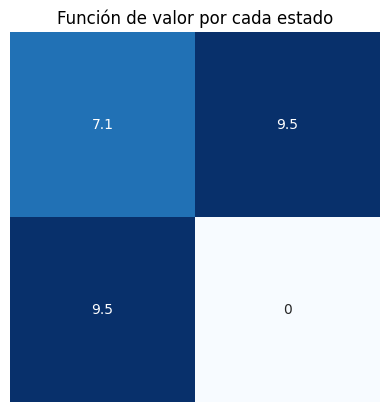

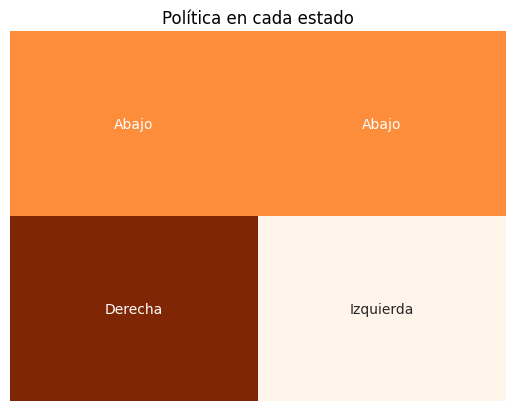

In [187]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env = VacuumGridEnv(grid=["SF", "FG"], slippery_chars={"S","F"})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env, discount=0.9)

values_print(val_fun_vec)
actions_print(policy_vec)

In [88]:
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
env.unwrapped.P                                                                                     

{0: {0: [(1.0, 0, -1, False)],
  1: [(0.8, 2, -1, False), (0.2, 0, -1, False)],
  2: [(0.8, 1, -1, False), (0.2, 0, -1, False)],
  3: [(1.0, 0, -1, False)]},
 1: {0: [(0.8, 0, -1, False), (0.2, 1, -1, False)],
  1: [(0.8, 3, 10, True), (0.2, 1, -1, False)],
  2: [(1.0, 1, -1, False)],
  3: [(1.0, 1, -1, False)]},
 2: {0: [(1.0, 2, -1, False)],
  1: [(1.0, 2, -1, False)],
  2: [(0.8, 3, 10, True), (0.2, 2, -1, False)],
  3: [(0.8, 0, -1, False), (0.2, 2, -1, False)]},
 3: {0: [(1.0, 3, 0, True)],
  1: [(1.0, 3, 0, True)],
  2: [(1.0, 3, 0, True)],
  3: [(1.0, 3, 0, True)]}}

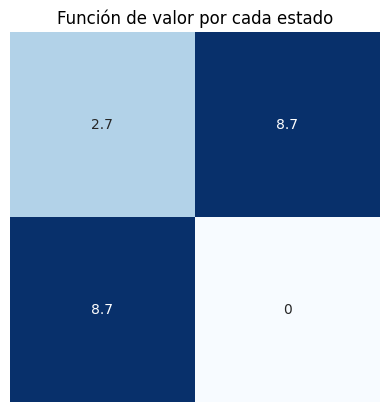

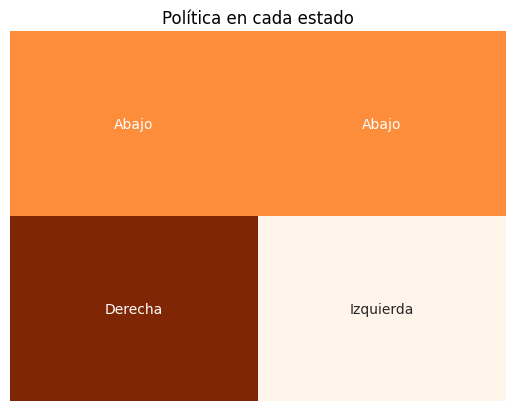

In [188]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env2 = VacuumGridEnv(grid=["SF", "FG"], slippery_chars={"S","F"})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env2, discount=0.5)

values_print(val_fun_vec)
actions_print(policy_vec)

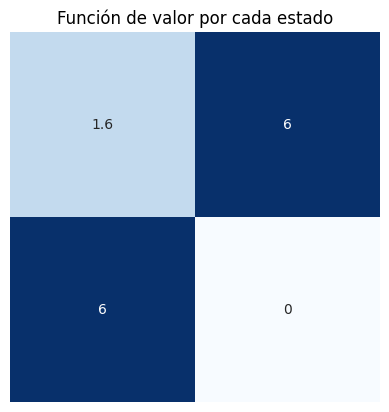

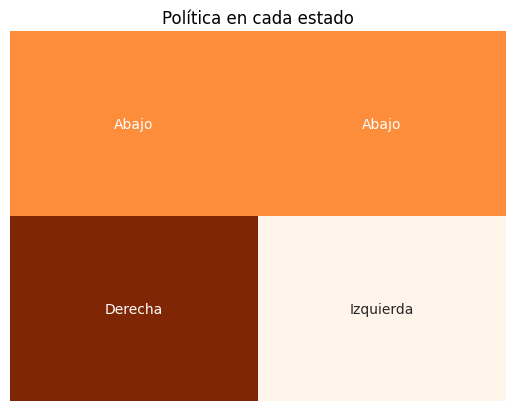

In [189]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env3 = VacuumGridEnv(grid=["SH", "HG"], slippery_chars={"S"}, carpet={"H"})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env3, discount=0.5)

values_print(val_fun_vec)
actions_print(policy_vec)

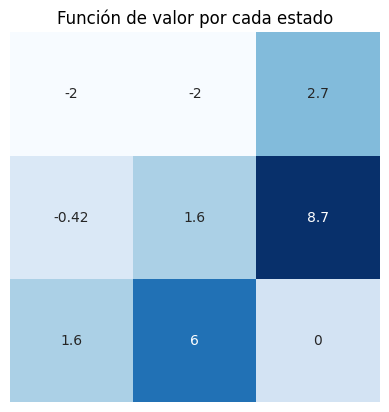

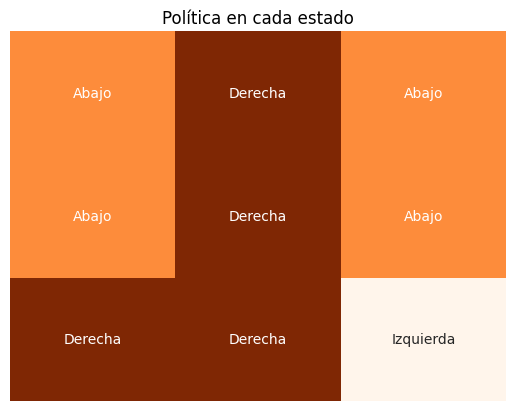

In [204]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env3 = VacuumGridEnv(grid=["SFF", "FHF",  "FHG"], slippery_chars={"S","F"}, carpet={"H"})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env3, discount=0.5)

values_print(val_fun_vec)
actions_print(policy_vec)

In [207]:
n_episodes_t = 2
for e in range(1, n_episodes_t+1):
    current_state = env3.reset()
    done = False
    score = 0
    actions = []
    while done == False:
        action = policy_vec[current_state]
        actions.append(action_names[action])
        state, reward, done, _,= env3.step(action)
        print(f"Estado: {current_state}, Acción: {action_names[action]}, Recompensa: {reward}, Siguiente Estado: {state}")
        score += reward
        current_state = state
    print('Episodio: {}\n\tAcciones: {};\n\tPuntaje: {}'.format(e, actions, score))


Estado: 0, Acción: Abajo, Recompensa: -1, Siguiente Estado: 3
Estado: 3, Acción: Abajo, Recompensa: -1, Siguiente Estado: 6
Estado: 6, Acción: Derecha, Recompensa: -1, Siguiente Estado: 7
Estado: 7, Acción: Derecha, Recompensa: -1, Siguiente Estado: 7
Estado: 7, Acción: Derecha, Recompensa: 10, Siguiente Estado: 8
Episodio: 1
	Acciones: ['Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha'];
	Puntaje: 6
Estado: 0, Acción: Abajo, Recompensa: -1, Siguiente Estado: 0
Estado: 0, Acción: Abajo, Recompensa: -1, Siguiente Estado: 3
Estado: 3, Acción: Abajo, Recompensa: -1, Siguiente Estado: 6
Estado: 6, Acción: Derecha, Recompensa: -1, Siguiente Estado: 7
Estado: 7, Acción: Derecha, Recompensa: -1, Siguiente Estado: 7
Estado: 7, Acción: Derecha, Recompensa: -1, Siguiente Estado: 7
Estado: 7, Acción: Derecha, Recompensa: 10, Siguiente Estado: 8
Episodio: 2
	Acciones: ['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha', 'Derecha'];
	Puntaje: 4


## Algoritmo value iteration

In [ ]:
def value_iteration(env, discount=0.9, tol=1e-4, max_iterations=1000):
    nS = env.observation_space.n
    nA = env.action_space.n
    V = np.zeros(nS)
    for i in range(max_iterations):
        delta = 0
        for s in range(nS):
            v = V[s]
            q_sa = np.zeros(nA)
            for a in range(nA):
                q_sa[a] = sum([prob * (reward + discount * V[next_state])
                               for prob, next_state, reward, done in env.unwrapped.P[s][a]])
            V[s] = np.max(q_sa)
            delta = max(delta, abs(v - V[s]))
        if delta < tol:
            break
    policy = np.zeros(nS, dtype=int)
    for s in range(nS):
        q_sa = np.zeros(nA)
        for a in range(nA):
            q_sa[a] = sum([prob * (reward + discount * V[next_state])
                           for prob, next_state, reward, done in env.unwrapped.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy, V

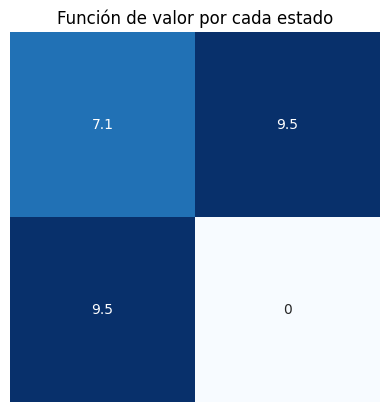

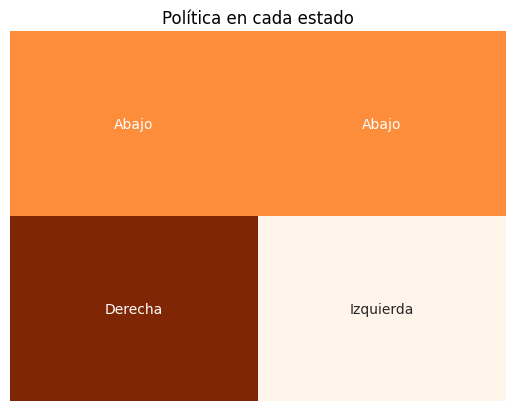

In [210]:
policy_vec, val_fun_vec = value_iteration(env, discount=0.9)
values_print(val_fun_vec)
actions_print(policy_vec)

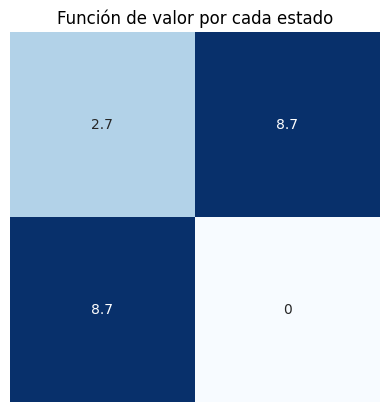

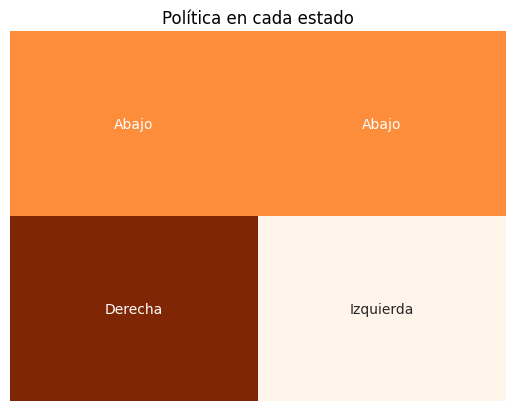

In [213]:
policy_vec, val_fun_vec = value_iteration(env2, discount=0.5)
values_print(val_fun_vec)
actions_print(policy_vec)

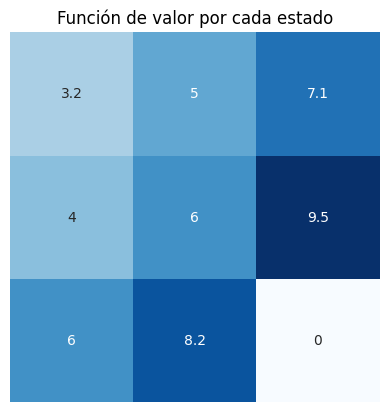

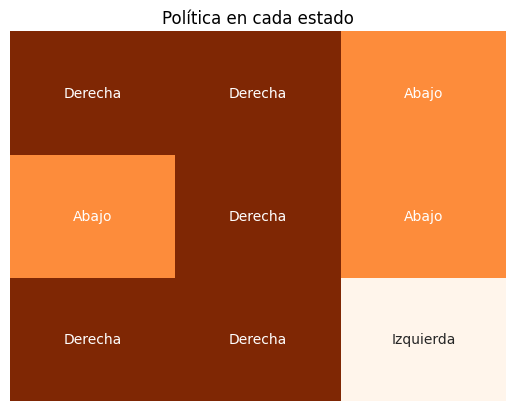

In [214]:
policy_vec, val_fun_vec = value_iteration(env3, discount=0.9)
values_print(val_fun_vec)
actions_print(policy_vec)

## Codigo de preguntas del ejemplo

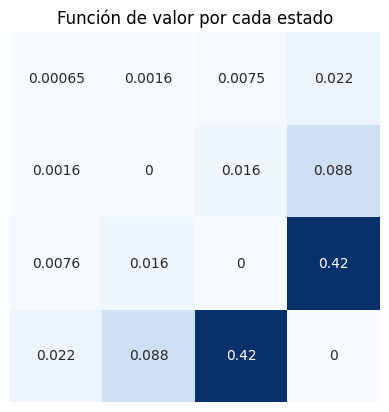

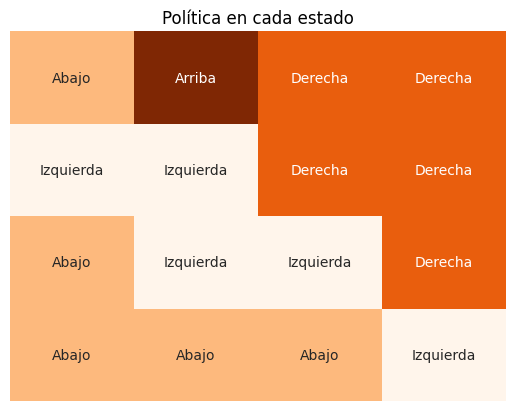

In [113]:
#creación del entorno
frozen = gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFHF", "FFFG"], is_slippery=True, render_mode="ansi")
action_names = {0:'Izquierda', 1:'Abajo', 2:'Derecha',3:'Arriba'}
policy_vec, val_fun_vec = policy_iteration(frozen, discount=0.5)
values_print(val_fun_vec)
actions_print(policy_vec)

In [122]:
frozen.reset()
n_episodes_t = 2
for e in range(1, n_episodes_t+1):
    current_state = frozen.reset()[0]
    done = False
    score = 0
    actions = []
    while done == False:
        #Acción ambiciosa
        action = policy_vec[current_state]
        actions.append(action_names[action])
        #Se obtienen los resultados del ambiente por la acción elegida
        state, reward, done, truncated, info= frozen.step(action)
        score += reward
        #Se transita al nuevo estado
        current_state = state
        print(f"state: {state}, action: {action_names[action]}, reward: {reward}, done: {done}, truncated: {truncated}")

        print(f"info {info}")

    print('Episodio: {}\n\tAcciones: {};\n\tPuntaje: {}'.format(e, actions, score))

frozen.close()

state: 0, action: Abajo, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 4, action: Abajo, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 0, action: Izquierda, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 1, action: Abajo, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 2, action: Arriba, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 6, action: Derecha, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 2, action: Derecha, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 6, action: Derecha, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 7, action: Derecha, reward: 0.0, done: False, truncated: False
info {'prob': 0.3333333333333333}
state: 11, action: Derecha, reward: 0.0, done: False, truncated: Fals

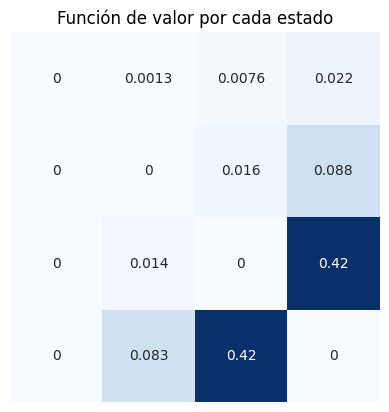

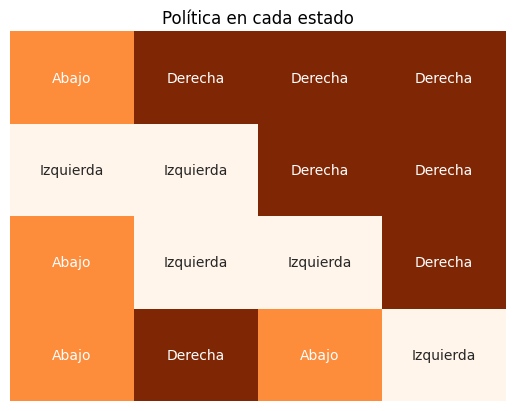

In [141]:
frozen2 = gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFHF", "FFFG"], is_slippery=True, render_mode="human")

def policy_iteration2(env, discount = 0.9, conv_tolerance=1e-4, max_iterations=100):
    """Algoritmo de iteración de política"""
    policy_stable_vec = np.zeros(env.observation_space.n, dtype=bool)
    val_fun_vec = np.zeros(env.observation_space.n)
    policy_vec = np.zeros(env.observation_space.n, dtype=int)
    #policy_vec = np.random.randint(0, env.action_space.n, size=env.observation_space.n, dtype=int)
    for _ in range(max_iterations):
        policy_vec, val_fun_vec = policy_evaluation(env, policy_vec, val_fun_vec, 
                                                                       conv_tolerance, discount=discount)
        policy_vec, policy_stable_vec = policy_improvement(env,policy_vec, val_fun_vec, policy_stable_vec, 
                                                           discount=discount)
        
        if np.all(policy_stable_vec == True):
            return policy_vec, val_fun_vec
policy_vec, val_fun_vec = policy_iteration2(frozen2, discount=0.5)
values_print(val_fun_vec)
actions_print(policy_vec)


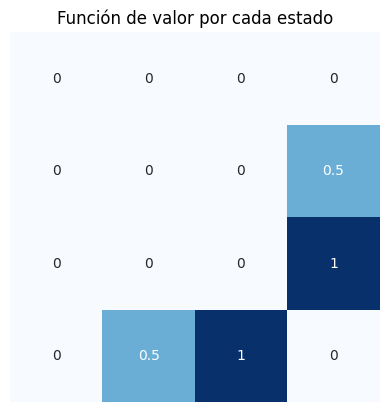

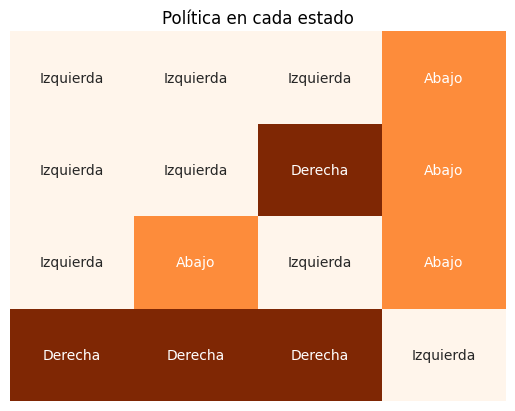

In [183]:
frozen3 = gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFHF", "FFFG"], is_slippery=False, render_mode="human")

policy_vec, val_fun_vec = policy_iteration(frozen3, discount=0.5)
values_print(val_fun_vec)
actions_print(policy_vec)

In [145]:
frozen3.unwrapped.P

{0: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 4, 0.0, False)],
  2: [(1.0, 1, 0.0, False)],
  3: [(1.0, 0, 0.0, False)]},
 1: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 5, 0.0, True)],
  2: [(1.0, 2, 0.0, False)],
  3: [(1.0, 1, 0.0, False)]},
 2: {0: [(1.0, 1, 0.0, False)],
  1: [(1.0, 6, 0.0, False)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 2, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False)],
  1: [(1.0, 7, 0.0, False)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 3, 0.0, False)]},
 4: {0: [(1.0, 4, 0.0, False)],
  1: [(1.0, 8, 0.0, False)],
  2: [(1.0, 5, 0.0, True)],
  3: [(1.0, 0, 0.0, False)]},
 5: {0: [(1.0, 5, 0, True)],
  1: [(1.0, 5, 0, True)],
  2: [(1.0, 5, 0, True)],
  3: [(1.0, 5, 0, True)]},
 6: {0: [(1.0, 5, 0.0, True)],
  1: [(1.0, 10, 0.0, True)],
  2: [(1.0, 7, 0.0, False)],
  3: [(1.0, 2, 0.0, False)]},
 7: {0: [(1.0, 6, 0.0, False)],
  1: [(1.0, 11, 0.0, False)],
  2: [(1.0, 7, 0.0, False)],
  3: [(1.0, 3, 0.0, False)]},
 8: {0: [(1.0, 8, 0.0, False)],
  1: [(1.0, 12, 0.0, F

In [111]:
import gymnasium as gym
env = gym.make("FrozenLake-v1")
print(env.step.__doc__)

Steps through the environment and if the number of steps elapsed exceeds ``max_episode_steps`` then truncate.

        Args:
            action: The environment step action

        Returns:
            The environment step ``(observation, reward, terminated, truncated, info)`` with `truncated=True`
            if the number of steps elapsed >= max episode steps

        
